In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Function
import numpy as np
from torchsummary import summary
import pandas as pd
from dataloader import *
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [6]:
label = pd.read_csv('train_label.csv') 
label = np.squeeze(label.values)
label.sort()

In [7]:
num_label = 4
total = 0
for num in label:
    if num==num_label:
        total +=1
    
print(total)
print(total/len(label)*100)

581
2.0676892416100214


In [8]:
plt.figure()
plt.hist(label)
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')


plt.show()

NameError: name 'plt' is not defined

In [ ]:
image_stats = []
train = RetinopathyLoader("./data/", "train")
train_loader = DataLoader(
    dataset=train, 
    batch_size=1
)   
# import loop
for x, y in train_loader:
    
    # import image
    x = x.numpy()
    y = y.numpy()
    # compute stats
#     print(x.shape)
    _, channels, height, width= x.shape
#     print(height, width, channels)
    ratio = width / height
    
    # save
    image_stats.append(np.array((height, width, channels, ratio)))

In [ ]:
# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['height', 'width', 'channels', 'ratio']

# create plot 
fig = plt.figure(figsize = (15, 5))

# width
plt.subplot(1, 3, 1)
plt.hist(image_stats['width'])
plt.title('(a) Image Width')
plt.ylabel('Number of examples')
plt.xlabel('Width')

# height
plt.subplot(1, 3, 2)
plt.hist(image_stats['height'])
plt.title('(b) Image Height')
plt.ylabel('Number of examples')
plt.xlabel('Height')

# ratio
plt.subplot(1, 3, 3)
plt.hist(image_stats['ratio'])
plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

> Found 28099 images...


/home/ubuntu/DLP/Lab3/dataloader.py:64: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  image = torch.tensor(image)
/home/ubuntu/DLP/Lab3/dataloader.py:64: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered int

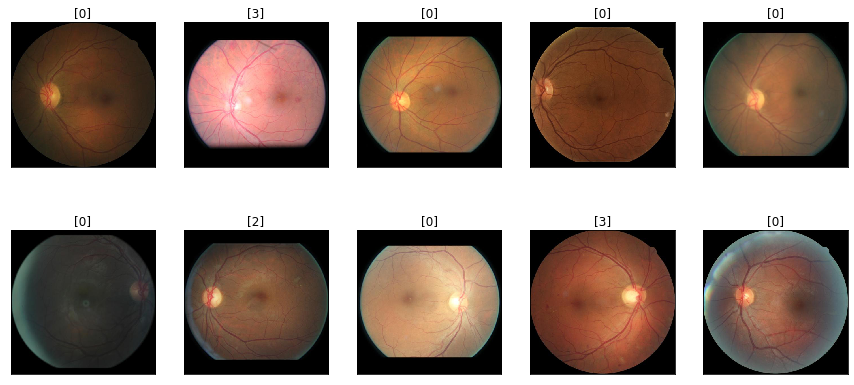

In [20]:
# transformations
sample_trains = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = RetinopathyLoader("./data/", "train", transform=sample_trains)
# sample = RetinopathyLoader("./data/", "train")

# data loader
sample_loader = DataLoader(dataset     = sample, 
                            batch_size  = 10, 
                            shuffle     = False, 
                            num_workers = 4)

# display images
for x, y in sample_loader:

    # extract data
    inputs = x
    labels = y.view(-1, 1)

    
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])
    break

In [21]:
#collapse-show
import cv2
### image preprocessing function
def prepare_image(image, sigmaX = 10, do_random_crop = False):
    
    
    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))
   
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)
    return image


### automatic crop of black areas
def crop_black(img, tol = 7):
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img
        
        
### circular crop around center
def circle_crop(img, sigmaX = 10):   
        
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)
    
    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img 


### random crop
def random_crop(img, size = (0.9, 1)):

    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]    
    
    return img

In [22]:
import torch
import pandas as pd
from torch.utils import data
import numpy as np
from PIL import Image
from torchvision import transforms

def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)


class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode, transform=None):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        self.transform = transform
        
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        """something you should implement here"""

        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'
           
           step2. Get the ground truth label from self.label
                     
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 
                       
                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 
                  
                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
                         
            step4. Return processed image and label
        """
        
        path = self.root + self.img_name[index] + '.jpeg'
        image = Image.open(path)
        image = np.asarray(image)    
        image = prepare_image(image) 
        image = torch.tensor(image)
        image = image.permute(2, 0, 1)
        
        if self.transform != None:
            image = self.transform(image)

        
        label = self.label[index]
        
        return image, label

> Found 28099 images...


/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


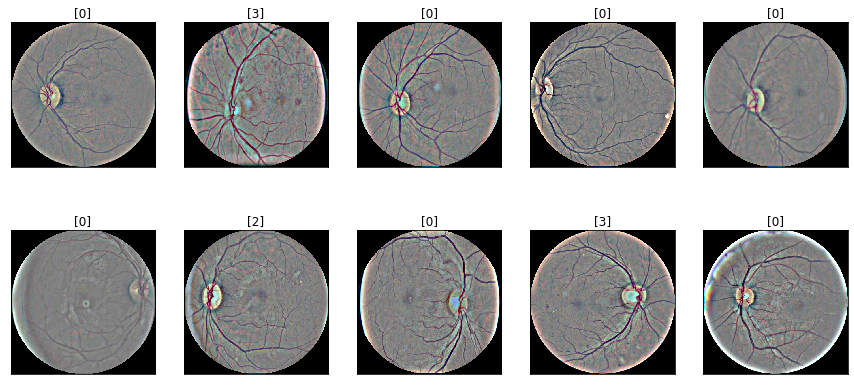

In [23]:
#collapse-show

##### EXAMINE SAMPLE BATCH

image_size = 512


# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = RetinopathyLoader("./data/", "train", transform=sample_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for x, y in sample_loader:

    # extract data
    inputs = x
    labels = y.view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break